# 4. Modelling

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from datetime import datetime
from tqdm import tqdm
import ruamel.yaml as yaml
import joblib
import json
import pandas as pd
import copy
import hashlib

### 0. Load Data & config

In [30]:
params_dir = '../config/params.yaml'

def load_params(params_dir):
  with open(params_dir, 'r') as file:
    params = yaml.safe_load(file)

    return params

params = load_params(params_dir)

In [31]:
x_rus = joblib.load(params['train_set_rus_path'][0])
y_rus = joblib.load(params['train_set_rus_path'][1])

x_ros = joblib.load(params['train_set_ros_path'][0])
y_ros = joblib.load(params['train_set_ros_path'][1])

x_sm = joblib.load(params['train_set_sm_path'][0])
y_sm = joblib.load(params['train_set_sm_path'][1])

x_valid = joblib.load(params['valid_feng_set_path'][0])
y_valid = joblib.load(params['valid_feng_set_path'][1])

x_test = joblib.load(params['test_feng_set_path'][0])
y_test = joblib.load(params['test_feng_set_path'][1])

### 1. Create Log Template

In [32]:
def time_stamp():
    return datetime.now()

In [33]:
def create_log_template():
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    return logger

In [34]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

### 2. Training and evaluation

### 2.1 Create Model Object

In [35]:
lgr_baseline = LogisticRegression(max_iter=2000000)
dct_baseline = DecisionTreeClassifier()
rfc_baseline = RandomForestClassifier()
knn_baseline = KNeighborsClassifier()
xgb_baseline = XGBClassifier()

In [36]:
list_of_model = {
    "undersampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    }

### 2.2 Training Model

In [37]:
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"]

        start_time = time_stamp()
        model["model_object"].fit(x_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model["model_object"].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

### 2.2.1 Baseline model undersampling

In [38]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "baseline_model",
    x_rus,
    y_rus,
    "undersampling",
    x_valid,
    y_valid,
    "../log/training_log.json"
)

100%|██████████| 5/5 [00:42<00:00,  8.50s/it]


In [39]:
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

### 2.2.2 Baseline model oversampling

In [40]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "baseline_model",
    x_rus,
    y_rus,
    "oversampling",
    x_valid,
    y_valid,
    "../log/training_log.json"
)

100%|██████████| 5/5 [00:45<00:00,  9.09s/it]


In [41]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

### 2.2.3 Baseline model smote

In [42]:
training_log, list_of_model_sm = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_rus,
    y_rus,
    "smote",
    x_valid,
    y_valid,
    "../log/training_log.json"
)

100%|██████████| 5/5 [00:41<00:00,  8.31s/it]


In [43]:
list_of_model["smote"] = copy.deepcopy(list_of_model_sm)

### 2.2.4 Best Performance

In [44]:
def training_log_to_df(training_log):
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(["f1_score_avg", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

In [45]:
training_res = training_log_to_df(training_log)
training_res

100%|██████████| 3/3 [00:00<00:00, 577.17it/s]


,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-KNeighborsClassifier,9937d7faa60dcf4860b9162290125df9,0.021412,2022-11-30 20:37:09.953047,"{'0': {'precision': 0.9822742596150361, 'recal...",0.767251,undersampling
1,baseline_model-KNeighborsClassifier,148b12e247ae999daf6ace27dc987697,0.021567,2022-11-30 20:39:10.943287,"{'0': {'precision': 0.9822742596150361, 'recal...",0.767251,smote
2,baseline_model-KNeighborsClassifier,e7d1c9ff13682ae9fb30d27f4d63584d,0.023308,2022-11-30 20:37:59.003419,"{'0': {'precision': 0.9822742596150361, 'recal...",0.767251,oversampling
3,baseline_model-LogisticRegression,a34d0662388606b02e6f1de64775bb12,4.299025,2022-11-30 20:38:55.173738,"{'0': {'precision': 0.992739439184268, 'recall...",0.753240,smote
4,baseline_model-LogisticRegression,4a155e2226f7df8b83a90ace2dd6e379,4.678877,2022-11-30 20:36:54.239219,"{'0': {'precision': 0.992739439184268, 'recall...",0.753240,undersampling
5,baseline_model-LogisticRegression,82d7249d7b58c41ddecd44c88fb9b3e1,5.203134,2022-11-30 20:37:41.912359,"{'0': {'precision': 0.992739439184268, 'recall...",0.753240,oversampling
6,baseline_model-XGBClassifier,e501ac2794347a40303a630abc1a5f21,3.819447,2022-11-30 20:39:32.647826,"{'0': {'precision': 0.9955911143997903, 'recal...",0.745549,smote
7,baseline_model-XGBClassifier,de0e96ede8711aaf9448834d4ee1cb23,4.101073,2022-11-30 20:38:23.003872,"{'0': {'precision': 0.9955911143997903, 'recal...",0.745549,oversampling
8,baseline_model-XGBClassifier,33fe7bd8fddc8f3791b900161b50b6b3,4.222093,2022-11-30 20:37:32.209532,"{'0': {'precision': 0.9955911143997903, 'recal...",0.745549,undersampling
9,baseline_model-RandomForestClassifier,a8ef1ed2446fcf4d756a9ae206e83c99,6.661445,2022-11-30 20:36:59.649078,"{'0': {'precision': 0.9931548653764438, 'recal...",0.733672,undersampling


In [46]:
def get_best_model(training_log_df, list_of_model):
    model_object = None

    best_model_info = training_log_df.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object
    

In [47]:
model = get_best_model(training_res, list_of_model)
model

KNeighborsClassifier()

### 2.2.4 Hyperparameter tuning

KNN model terbaik tapi f1_score_avg masih 0.767251

In [49]:
dist_params_knn = {
    "algorithm" : ["ball_tree", "kd_tree", "brute"],
    "n_neighbors" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
    "leaf_size" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
}

In [50]:
knn_enh = GridSearchCV(KNeighborsClassifier(), dist_params_knn, n_jobs = -1, verbose = 420)

In [51]:
list_of_model["undersampling"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})
list_of_model["oversampling"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})
list_of_model["smote"].append({"model_name": knn_enh.__class__.__name__ + "-" + knn_enh.estimator.__class__.__name__, "model_object": copy.deepcopy(knn_enh), "model_uid": ""})

In [52]:
training_log, list_of_model_rus_hyp = train_eval_model(
    [list_of_model["undersampling"][-1]],
    "hyperparams",
    x_rus,
    y_rus,
    "undersampling",
    x_valid,
    y_valid,
    "../log/training_log.json"
)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5; 1/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=2...........
[CV 2/5; 2/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=3...........
[CV 1/5; 2/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=3...........[CV 5/5; 1/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=2...........
[CV 4/5; 1/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=2...........

[CV 2/5; 1/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=2...........
[CV 3/5; 1/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=2...........
[CV 3/5; 2/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=3...........
[CV 1/5; 1/243] END algorithm=ball_tree, leaf_size=2, n_neighbors=2;, score=0.771 total time=  11.6s
[CV 3/5; 1/243] END algorithm=ball_tree, leaf_size=2, n_neighbors=2;, score=0.776 total time=  11.5s
[CV 4/5; 2/243] START algorithm=ball_tree, leaf_size=2, n_neighbors=3...........
[CV 5

100%|██████████| 1/1 [40:09<00:00, 2409.08s/it]


In [53]:
list_of_model["undersampling"][-1] = copy.deepcopy(list_of_model_rus_hyp[0])

In [54]:
list_of_model["undersampling"][-1]

{'model_name': 'GridSearchCV-KNeighborsClassifier',
 'model_object': GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
              param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'leaf_size': [2, 3, 4, 5, 6, 10, 15, 20, 25],
                          'n_neighbors': [2, 3, 4, 5, 6, 10, 15, 20, 25]},
              verbose=420),
 'model_uid': 'a397c1873d92d32ce83250d6bf3d3e35'}

In [55]:
training_res = training_log_to_df(training_log)
training_res

100%|██████████| 4/4 [00:00<00:00, 299.63it/s]


,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-KNeighborsClassifier,9937d7faa60dcf4860b9162290125df9,0.021412,2022-11-30 20:37:09.953047,"{'0': {'precision': 0.9822742596150361, 'recal...",0.767251,undersampling
1,baseline_model-KNeighborsClassifier,148b12e247ae999daf6ace27dc987697,0.021567,2022-11-30 20:39:10.943287,"{'0': {'precision': 0.9822742596150361, 'recal...",0.767251,smote
2,baseline_model-KNeighborsClassifier,e7d1c9ff13682ae9fb30d27f4d63584d,0.023308,2022-11-30 20:37:59.003419,"{'0': {'precision': 0.9822742596150361, 'recal...",0.767251,oversampling
3,hyperparams-GridSearchCV-KNeighborsClassifier,a397c1873d92d32ce83250d6bf3d3e35,2388.484101,2022-11-30 20:40:55.975608,"{'0': {'precision': 0.989378389279792, 'recall...",0.758915,undersampling
4,baseline_model-LogisticRegression,a34d0662388606b02e6f1de64775bb12,4.299025,2022-11-30 20:38:55.173738,"{'0': {'precision': 0.992739439184268, 'recall...",0.753240,smote
5,baseline_model-LogisticRegression,4a155e2226f7df8b83a90ace2dd6e379,4.678877,2022-11-30 20:36:54.239219,"{'0': {'precision': 0.992739439184268, 'recall...",0.753240,undersampling
6,baseline_model-LogisticRegression,82d7249d7b58c41ddecd44c88fb9b3e1,5.203134,2022-11-30 20:37:41.912359,"{'0': {'precision': 0.992739439184268, 'recall...",0.753240,oversampling
7,baseline_model-XGBClassifier,e501ac2794347a40303a630abc1a5f21,3.819447,2022-11-30 20:39:32.647826,"{'0': {'precision': 0.9955911143997903, 'recal...",0.745549,smote
8,baseline_model-XGBClassifier,de0e96ede8711aaf9448834d4ee1cb23,4.101073,2022-11-30 20:38:23.003872,"{'0': {'precision': 0.9955911143997903, 'recal...",0.745549,oversampling
9,baseline_model-XGBClassifier,33fe7bd8fddc8f3791b900161b50b6b3,4.222093,2022-11-30 20:37:32.209532,"{'0': {'precision': 0.9955911143997903, 'recal...",0.745549,undersampling


### 3. Confusion matrix

In [56]:
y_pred = model.predict(x_valid)

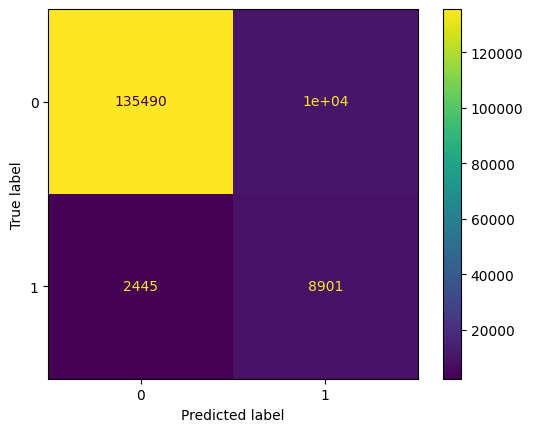

In [95]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)

In [96]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    145940
           1       0.46      0.78      0.58     11346

    accuracy                           0.92    157286
   macro avg       0.72      0.86      0.77    157286
weighted avg       0.94      0.92      0.93    157286



In [98]:
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    145853
           1       0.46      0.78      0.58     11434

    accuracy                           0.92    157287
   macro avg       0.72      0.85      0.77    157287
weighted avg       0.94      0.92      0.93    157287



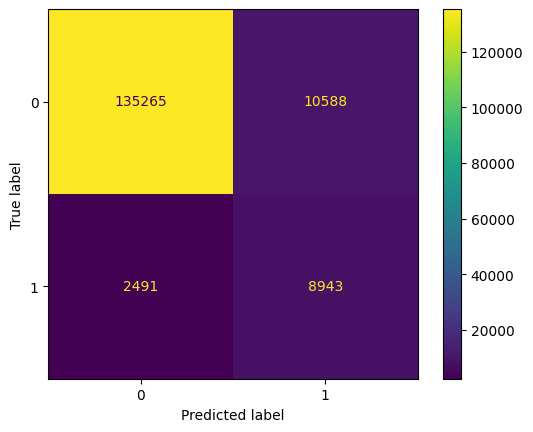

In [100]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [101]:
joblib.dump(model, params['production_model_path'])

['../models/production_model.pkl']